In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.100)

import numpy as np
import time
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 4, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')

# Feature graph

4166 > 4096 edges
Execution time: 0.38s
[matrix([[ 0.        , -0.1979436 , -0.11081555, ...,  0.        ,
          0.        ,  0.        ],
        [-0.1979436 ,  0.        , -0.17384297, ...,  0.        ,
          0.        ,  0.        ],
        [-0.11081555, -0.17384297,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]], dtype=float32), matrix([[ 0.        , -0.23986164, -0.19766776, ...,  0.        ,
          0.        ,  0.        ],
        [-0.23986161,  0.        , -0.14583169, ...,  0.        ,
          0.        ,  0.        ],
        [-0.19766776, -0.14583169,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..

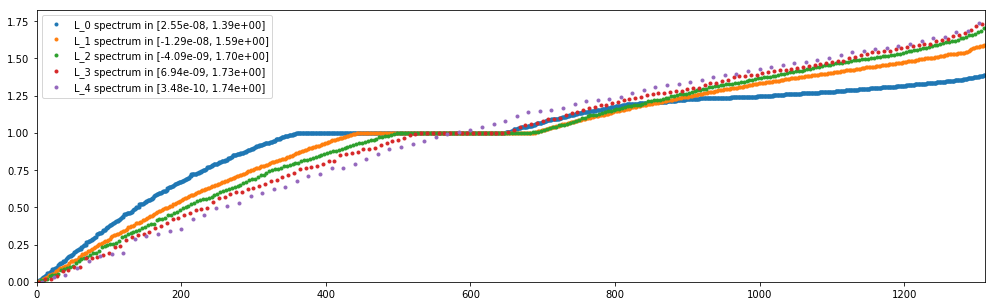

In [3]:
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))

    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(32, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)

L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
graph.plot_spectrum(L)
L = [A.toarray() for A in L]
L = [graph.rescale_L(A) for A in L]
print(L, L[0].shape,L[1].shape, L[2].shape,L[3].shape,L[4].shape)

#del A

# Data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(FLAGS.dir_data, one_hot=False)

train_data = mnist.train.images.astype(np.float32)
val_data = mnist.validation.images.astype(np.float32)
test_data = mnist.test.images.astype(np.float32)
train_labels = np_utils.to_categorical(mnist.train.labels)
val_labels = np_utils.to_categorical(mnist.validation.labels)
test_labels = np_utils.to_categorical(mnist.test.labels)

t_start = time.process_time()
train_data = coarsening.perm_data(train_data, perm)
val_data = coarsening.perm_data(val_data, perm)
test_data = coarsening.perm_data(test_data, perm)
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))


L = np.array(L)
single_laplacian =  np.array([q for q in L])
print(single_laplacian)
train_laplacians = []
for j in range(L.shape[0]):
    train_laplacians.append([single_laplacian[j] for i in range(55000)])                        
val_laplacians = []
for j in range(L.shape[0]):
    val_laplacians.append([single_laplacian[j] for i in range(5000)])
test_laplacians = []
for j in range(L.shape[0]):
    test_laplacians.append([single_laplacian[j] for i in range(10000)])


#del perm

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
Execution time: 0.80s
[ matrix([[ 0.        , -0.1979436 , -0.11081555, ...,  0.        ,
          0.        ,  0.        ],
        [-0.1979436 ,  0.        , -0.17384297, ...,  0.        ,
          0.        ,  0.        ],
        [-0.11081555, -0.17384297,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]], dtype=float32)
 matrix([[ 0.        , -0.23986164, -0.19766776, ...,  0.        ,
          0.        ,  0.        ],
        [-0.23986161,  0.

# Neural networks

In [5]:
common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 20
common['batch_size']     = 100
common['decay_steps']    = mnist.train.num_examples / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
num_labels_per_image     = 1
C = max(mnist.train.labels) + 1  # number of classes

model_perf = utils.model_perf()

In [6]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 5e-4
    params['dropout']        = 1
    params['learning_rate']  = 0.02
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['F_0']            = 1
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    params['train_laplacians'] = train_laplacians
    params['test_laplacians'] = val_laplacians
    params['val_laplacians'] = test_laplacians
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1312
  layer 1: logits (softmax)
    representation: M_1 = 10
    weights: M_0 * M_1 = 1312 * 10 = 13120
    biases: M_1 = 10
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 8.45e-01
4508.0 / 5000.0 = 0.9016
  validation precision: 0.90, recall : 0.90, f_measure: 0.90, mAP 0.99, MAP 0.90
  time: 40s (wall 46s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 8.17e-01
4546.0 / 5000.0 = 0.9092
  validation precision: 0.91, recall : 0.91, f_measure: 0.91, mAP 0.99, MAP 0.91
  time: 44s (wall 48s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 7.76e-01
4545.0 / 5000.0 = 0.909
  validation precision: 0.91, recall : 0.91, f_measure: 0.91, mAP 0.99, MAP 0.91
  time: 48s (wall 50s)
step 2400 / 11000 (epoch 4.36 / 20):
  learning_rate = 1.63e-02, loss_average = 7.97e-01
4563.0 / 5000.0 = 0.9126
  validation precision: 0.91, recall : 0.91, f_measure: 0.91, mAP 0.99, MAP 0

In [7]:
# Common hyper-parameters for networks with one convolutional layer.
common['regularization'] = 0
common['dropout']        = 1
common['learning_rate']  = 0.02
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [10]
common['F_0']            = 1
common['K']              = [20]
common['p']              = [4]
common['M']              = [C]
common['train_laplacians'] = train_laplacians
common['test_laplacians'] = test_laplacians
common['val_laplacians'] = val_laplacians

In [8]:
# With 'chebyshev2' and 'b2relu', it corresponds to cgcnn2_2(L[0], F=10, K=20).
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
#    params['filter'] = 'chebyshev2'
#    params['brelu'] = 'b2relu'
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1312
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1312 * 10 / 4 = 3280
    weights: F_0 * F_1 * K_1 = 1 * 10 * 20 = 200
    biases: F_1 = 10
  layer 2: logits (softmax)
    representation: M_2 = 10
    weights: M_1 * M_2 = 3280 * 10 = 32800
    biases: M_2 = 10
0 th conv layer 100 1312 1312
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 5.77e-01
4661.0 / 5000.0 = 0.9322
  validation precision: 0.93, recall : 0.93, f_measure: 0.93, mAP 1.00, MAP 0.93
  time: 384s (wall 392s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 4.46e-01
4699.0 / 5000.0 = 0.9398
  validation precision: 0.94, recall : 0.94, f_measure: 0.94, mAP 1.00, MAP 0.94
  time: 745s (wall 756s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_rate = 1.71e-02, loss_average = 4.15e-01
4744.0 / 5000.0 = 0.9488
  validation precision: 0.95, recall : 0.95, f_measure: 0.95, mAP 1.00, MAP 0.95
  time: 1180s (wall 1262s)
step

In [11]:
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [15, 10]
common['F_0']            = 1
common['K']              = [25, 25]
common['p']              = [4, 2]
common['M']              = [C]
common['train_laplacians'] = train_laplacians
common['test_laplacians'] = test_laplacians
common['val_laplacians'] = val_laplacians

In [12]:
if True:
    name = 'cgconv_cgconv_fc_softmax'  # 'Chebyshev'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1312
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1312 * 15 / 4 = 4920
    weights: F_0 * F_1 * K_1 = 1 * 15 * 25 = 375
    biases: F_1 = 15
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 328 * 10 / 2 = 1640
    weights: F_1 * F_2 * K_2 = 15 * 10 * 25 = 3750
    biases: F_2 = 10
  layer 3: logits (softmax)
    representation: M_3 = 10
    weights: M_2 * M_3 = 1640 * 10 = 16400
    biases: M_3 = 10
0 th conv layer 100 1312 1312
1 th conv layer 100 328 328
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 5.47e-01
4693.0 / 5000.0 = 0.9386
  validation precision: 0.94, recall : 0.94, f_measure: 0.94, mAP 1.00, MAP 0.94
  time: 472s (wall 483s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 4.09e-01
4772.0 / 5000.0 = 0.9544
  validation precision: 0.95, recall : 0.95, f_measure: 0.95, mAP 1.00, MAP 0.95
  time: 944s (wall 965s)
step 1800 / 11000 (epoch 3.27 / 20):
  learning_r

In [ ]:
model_perf.show()

In [ ]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))

In [ ]:
# Common hyper-parameters for LeNet5-like networks.
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64]
common['F_0']            = 1
common['K']              = [25, 25]
common['p']              = [4, 2]
common['M']              = [512, C]
common['train_laplacians'] = train_laplacians
common['test_laplacians'] = test_laplacians
common['val_laplacians'] = val_laplacians
if True:
    name = 'cgconv_cgconv_fc_softmax'  # 'Chebyshev'
    params = common.copy()
    params['dir_name'] += name
    params['filter'] = 'chebyshev5'
    model_perf.test(models.cgcnn(L, num_labels_per_image, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

NN architecture
  input: M_0 = 1312
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1312 * 32 / 4 = 10496
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 328 * 64 / 2 = 10496
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 10496 * 512 = 5373952
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 10
    weights: M_3 * M_4 = 512 * 10 = 5120
    biases: M_4 = 10
0 th conv layer 100 1312 1312
1 th conv layer 100 328 328
step 600 / 11000 (epoch 1.09 / 20):
  learning_rate = 1.90e-02, loss_average = 1.30e+01
479.0 / 5000.0 = 0.0958
  validation precision: 0.01, recall : 0.10, f_measure: 0.02, mAP 0.10, MAP 0.10
  time: 468s (wall 499s)
step 1200 / 11000 (epoch 2.18 / 20):
  learning_rate = 1.80e-02, loss_average = 1.19e+01
563.0 / 5000.0 = 0.1126
  validation precision: 0.01, recall : 0.1